In [14]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from typing import Optional, List, Tuple, Dict


In [15]:
# Set path to include our custom modules
module_path = os.path.join(os.path.dirname(os.getcwd()), "celltrajectory")
if os.path.exists(module_path):
    sys.path.append(os.path.dirname(os.getcwd()))
    try:
        from celltrajectory.trajectory import pseudotime, rare_population
        print("Successfully imported custom modules")
    except ImportError as e:
        print(f"Error importing modules: {e}")
        # Define inline functions if import fails
        use_inline_functions = True
else:
    print(f"Module path not found: {module_path}")
    print("Creating pseudotime and rare_population functions inline...")
    use_inline_functions = True

Successfully imported custom modules


Using data from: C:\PRASHANTH\github projects\CellTrajectory-Developmental-Path-Modeling-System\data\processed
Loading processed data: C:\PRASHANTH\github projects\CellTrajectory-Developmental-Path-Modeling-System\data\processed\velten_hematopoiesis_processed.h5ad
Loaded data with shape: (2277, 4955)

Data structure:
Observation keys: ['sample_id', 'plate', 'well_letter', 'well_number', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'leiden']
Uns keys: ['hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'plate_colors', 'rank_genes_groups', 'umap', 'well_letter_colors']
Obsm keys: ['X_pca', 'X_umap']

Computing pseudotime ordering...
HSC cell type not found, using first leiden cluster as root
Using cluster 0 as root


<Figure size 1000x800 with 0 Axes>

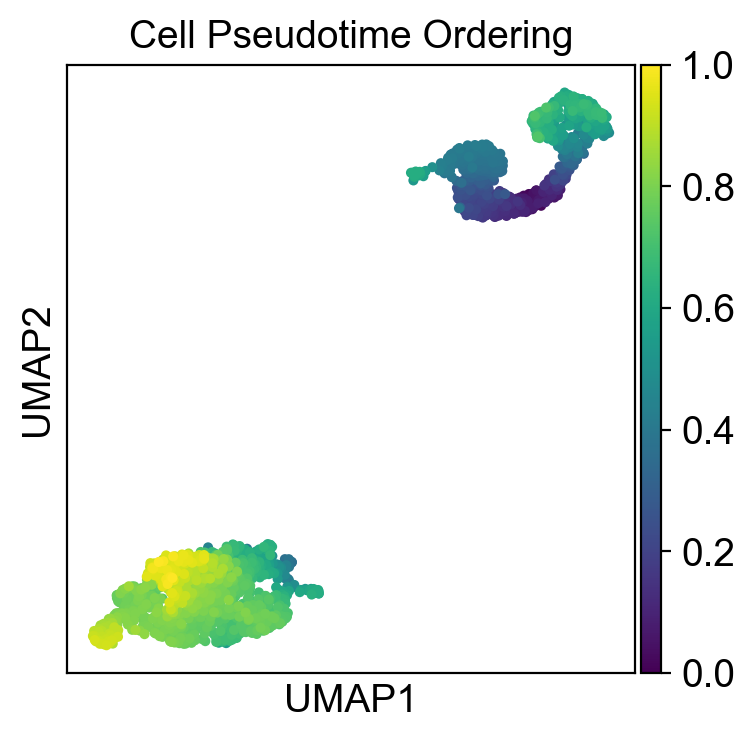

In [16]:
# Define functions inline if needed
if 'use_inline_functions' in locals() and use_inline_functions:
    print("Using inline function definitions")
    
    def compute_pseudotime(
        adata, 
        root_cells=None, 
        root_cluster=None, 
        n_dcs=15, 
        use_leiden=True
    ):
        """Compute pseudotime ordering of cells."""
        # Make a copy to avoid modifying original
        adata = adata.copy()
        
        # Calculate diffusion map
        sc.tl.diffmap(adata, n_comps=n_dcs)
        
        # Determine root cells
        if root_cells is None and root_cluster is not None:
            cluster_key = 'leiden' if use_leiden else 'louvain'
            if cluster_key not in adata.obs:
                raise ValueError(f"Cluster key '{cluster_key}' not found in adata.obs")
            root_cells = adata.obs[cluster_key] == root_cluster
            
        if root_cells is None:
            # Use cell with lowest diffusion component 1 as root
            root_idx = np.argmin(adata.obsm['X_diffmap'][:, 1])
            adata.uns['iroot'] = int(root_idx)
        elif isinstance(root_cells, np.ndarray) and root_cells.dtype == bool:
            # Convert boolean mask to index
            root_idx = np.where(root_cells)[0][0]
            adata.uns['iroot'] = int(root_idx)
        elif isinstance(root_cells, pd.Series):
            # Convert Series boolean mask to index
            root_idx = np.where(root_cells.values)[0][0]
            adata.uns['iroot'] = int(root_idx)
        else:
            # Assume root_cells is already an index
            adata.uns['iroot'] = int(root_cells)
        
        # Compute DPT pseudotime
        sc.tl.dpt(adata)
        return adata

    def compute_trajectory_graph(
        adata, 
        use_paga=True, 
        use_umap=True, 
        root_cluster=None
    ):
        """Compute a graph representation of the trajectory."""
        if 'leiden' not in adata.obs:
            sc.tl.leiden(adata)
        
        if use_paga:
            sc.tl.paga(adata, groups='leiden')
            
            if root_cluster is not None:
                root_idx = np.where(adata.obs['leiden'] == root_cluster)[0][0]
                adata.uns['iroot'] = int(root_idx)
                sc.tl.dpt(adata)
        
        if use_umap and 'X_umap' not in adata.obsm:
            sc.tl.umap(adata)
        
        return adata
    
    def identify_rare_populations(
        adata, 
        min_cells=10, 
        isolation_score_threshold=0.8, 
        cluster_key='leiden'
    ):
        """Identify rare cell populations based on size and isolation metrics."""
        if cluster_key not in adata.obs:
            raise ValueError(f"Cluster key '{cluster_key}' not found in adata.obs")
        
        # Calculate cluster sizes
        cluster_sizes = adata.obs[cluster_key].value_counts()
        small_clusters = cluster_sizes[cluster_sizes < min_cells].index.tolist()
        
        if not small_clusters:
            print("No small clusters found")
            return [], pd.DataFrame()
        
        if 'neighbors' not in adata.uns:
            sc.pp.neighbors(adata)
        
        connectivities = adata.obsp['connectivities']
        isolation_scores = {}
        
        for cluster in small_clusters:
            cluster_mask = adata.obs[cluster_key] == cluster
            if sum(cluster_mask) == 0:
                continue
                
            cluster_indices = np.where(cluster_mask)[0]
            within_connections = connectivities[np.ix_(cluster_indices, cluster_indices)].sum()
            total_connections = connectivities[cluster_indices].sum()
            
            if total_connections > 0:
                isolation_scores[cluster] = 1 - (within_connections / total_connections)
            else:
                isolation_scores[cluster] = 1.0
        
        # Identify rare and isolated populations
        rare_populations = [
            cluster for cluster in small_clusters 
            if isolation_scores.get(cluster, 0) > isolation_score_threshold
        ]
        
        # Create results DataFrame
        results = pd.DataFrame({
            'cluster': small_clusters,
            'size': [cluster_sizes[c] for c in small_clusters],
            'isolation_score': [isolation_scores.get(c, 0) for c in small_clusters],
            'is_rare': [c in rare_populations for c in small_clusters]
        })
        
        return rare_populations, results

    def predict_developmental_paths(
        adata, 
        rare_cluster, 
        root_cluster='HSC', 
        n_waypoints=10, 
        pseudotime_key='dpt_pseudotime', 
        cluster_key='leiden'
    ):
        """Predict developmental path from root cluster to rare population."""
        if cluster_key not in adata.obs:
            raise ValueError(f"Cluster key '{cluster_key}' not found in adata.obs")
        
        # Get cells in root and target clusters
        root_indices = np.where(adata.obs[cluster_key] == root_cluster)[0]
        target_indices = np.where(adata.obs[cluster_key] == rare_cluster)[0]
        
        if len(root_indices) == 0:
            raise ValueError(f"Root cluster '{root_cluster}' has no cells")
        if len(target_indices) == 0:
            raise ValueError(f"Target cluster '{rare_cluster}' has no cells")
        
        # Set root for pseudotime calculation
        adata.uns['iroot'] = int(root_indices[0])
        
        if pseudotime_key not in adata.obs or np.isnan(adata.obs[pseudotime_key]).all():
            sc.tl.dpt(adata)
        
        pseudotime = adata.obs[pseudotime_key].values
        
        # Find a representative path between root and target
        root_pt = np.median(pseudotime[root_indices])
        target_pt = np.median(pseudotime[target_indices])
        
        path_pts = np.linspace(root_pt, target_pt, n_waypoints)
        
        path_indices = []
        for pt in path_pts:
            closest_cell = np.argmin(np.abs(pseudotime - pt))
            path_indices.append(closest_cell)
        
        return path_indices
    
    # Assign functions to module names for consistent interface
    class PseudotimeModule:
        def __init__(self):
            self.compute_pseudotime = compute_pseudotime
            self.compute_trajectory_graph = compute_trajectory_graph
            
    class RarePopulationModule:
        def __init__(self):
            self.identify_rare_populations = identify_rare_populations
            self.predict_developmental_paths = predict_developmental_paths
            
    pseudotime = PseudotimeModule()
    rare_population = RarePopulationModule()

# Set plotting parameters
sc.settings.set_figure_params(dpi=100, facecolor='white')
%matplotlib inline

# Define the path to the processed directory
processed_dir = r"C:\PRASHANTH\github projects\CellTrajectory-Developmental-Path-Modeling-System\data\processed"
print(f"Using data from: {processed_dir}")

# Load the processed data
processed_file = os.path.join(processed_dir, "velten_hematopoiesis_processed.h5ad")
if os.path.exists(processed_file):
    print(f"Loading processed data: {processed_file}")
    adata = sc.read_h5ad(processed_file)
else:
    # Fall back to raw data if processed doesn't exist
    print(f"Processed file not found: {processed_file}")
    print("Loading raw data instead...")
    raw_file = os.path.join(processed_dir, "velten_hematopoiesis_raw.h5ad")
    adata = sc.read_h5ad(raw_file)
    
    # Basic preprocessing if using raw data
    print("Performing basic preprocessing...")
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata = adata[:, adata.var.highly_variable]
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.5)

print(f"Loaded data with shape: {adata.shape}")

# Check data structure
print("\nData structure:")
print(f"Observation keys: {list(adata.obs.keys())}")
print(f"Uns keys: {list(adata.uns.keys())}")
if 'obsm' in dir(adata):
    print(f"Obsm keys: {list(adata.obsm.keys())}")

# Compute pseudotime
print("\nComputing pseudotime ordering...")
if 'predicted_cell_type' in adata.obs and 'HSC' in adata.obs['predicted_cell_type'].values:
    print("Using HSC cell type as root")
    root_cells = adata.obs['predicted_cell_type'] == 'HSC'
    # Convert Series to array and find the first index
    root_idx = np.where(root_cells.values)[0][0]
    # Set the root index manually
    adata.uns['iroot'] = int(root_idx)
    # Then run pseudotime calculation
    adata = pseudotime.compute_pseudotime(adata)
else:
    print("HSC cell type not found, using first leiden cluster as root")
    if 'leiden' in adata.obs:
        leiden_clusters = adata.obs['leiden'].cat.categories
        root_cluster = leiden_clusters[0]
        print(f"Using cluster {root_cluster} as root")
        root_cells = adata.obs['leiden'] == root_cluster
        # Manual approach to avoid Series issue
        root_idx = np.where(root_cells.values)[0][0]
        adata.uns['iroot'] = int(root_idx)
        # Direct approach using scanpy
        sc.tl.dpt(adata)
    else:
        print("No clustering found. Generating leiden clusters first...")
        sc.tl.leiden(adata, resolution=0.5)
        leiden_clusters = adata.obs['leiden'].cat.categories
        root_cluster = leiden_clusters[0]
        print(f"Using cluster {root_cluster} as root")
        root_cells = adata.obs['leiden'] == root_cluster
        root_idx = np.where(root_cells.values)[0][0]
        adata.uns['iroot'] = int(root_idx)
        sc.tl.dpt(adata)

# Visualize pseudotime
plt.figure(figsize=(10, 8))
sc.pl.umap(adata, color='dpt_pseudotime', cmap='viridis', title="Cell Pseudotime Ordering")

In [12]:
def compute_pseudotime(
    adata: AnnData,
    root_cells: Optional[np.ndarray] = None,
    root_cluster: Optional[str] = None,
    n_dcs: int = 15,
    use_leiden: bool = True
) -> AnnData:
    """
    Compute pseudotime ordering of cells.
    """
    # Make a copy to avoid modifying original
    adata = adata.copy()
    
    # Calculate diffusion map
    sc.tl.diffmap(adata, n_comps=n_dcs)
    
    # Determine root cells
    if root_cells is None and root_cluster is not None:
        if use_leiden:
            cluster_key = 'leiden'
        else:
            cluster_key = 'louvain'
            
        if cluster_key not in adata.obs:
            raise ValueError(f"Cluster key '{cluster_key}' not found in adata.obs")
            
        root_cells = adata.obs[cluster_key] == root_cluster
        
    if root_cells is None:
        # Use cell with lowest diffusion component 1 as root
        root_idx = np.argmin(adata.obsm['X_diffmap'][:, 1])
        adata.uns['iroot'] = int(root_idx)  # Ensure it's an integer
    elif isinstance(root_cells, np.ndarray) and root_cells.dtype == bool:
        # Convert boolean mask to index
        root_idx = np.where(root_cells)[0][0]
        adata.uns['iroot'] = int(root_idx)  # Ensure it's an integer
    elif isinstance(root_cells, pd.Series):  # Handle pandas Series explicitly
        # Convert Series boolean mask to index
        root_idx = np.where(root_cells.values)[0][0]
        adata.uns['iroot'] = int(root_idx)  # Ensure it's an integer
    else:
        # Assume root_cells is already an index
        adata.uns['iroot'] = int(root_cells)  # Ensure it's an integer
    
    # Compute DPT pseudotime
    sc.tl.dpt(adata)
    
    return adata


Creating trajectory graph...


<Figure size 1200x1000 with 0 Axes>

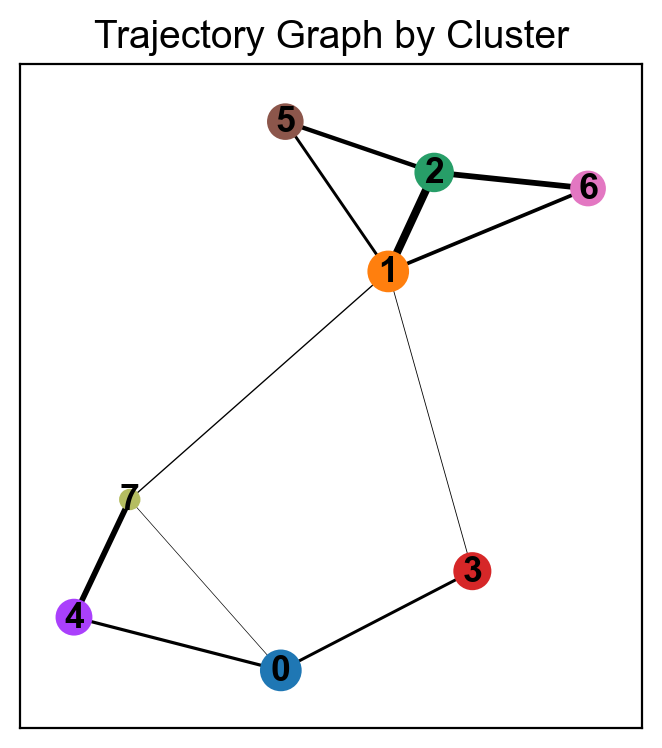


Identifying rare populations...
No small clusters found
Identified 0 rare populations
No rare populations identified.

Saving trajectory analysis results to: C:\PRASHANTH\github projects\CellTrajectory-Developmental-Path-Modeling-System\data\processed\velten_hematopoiesis_trajectory.h5ad
Trajectory analysis complete!


In [17]:
# Create trajectory graph
print("\nCreating trajectory graph...")
try:
    adata = pseudotime.compute_trajectory_graph(adata, use_paga=True)
except Exception as e:
    print(f"Error computing trajectory graph: {e}")
    print("Using direct scanpy approach...")
    sc.tl.paga(adata, groups='leiden')

# Visualize trajectory
plt.figure(figsize=(12, 10))
sc.pl.paga(adata, color='leiden', threshold=0.03, title="Trajectory Graph by Cluster")

if 'predicted_cell_type' in adata.obs:
    plt.figure(figsize=(12, 10))
    sc.pl.paga(adata, color='predicted_cell_type', threshold=0.03, title="Trajectory Graph by Cell Type")

# Identify rare populations
print("\nIdentifying rare populations...")
try:
    rare_pops, rare_metrics = rare_population.identify_rare_populations(
        adata, min_cells=10, isolation_score_threshold=0.8)
    print(f"Identified {len(rare_pops)} rare populations")

    if rare_metrics.shape[0] > 0:
        print("Rare population metrics:")
        print(rare_metrics)

        # Mark rare populations in the data
        adata.obs['is_rare'] = adata.obs['leiden'].isin(rare_pops)

        # Visualize rare populations
        plt.figure(figsize=(10, 8))
        sc.pl.umap(adata, color=['is_rare'], palette=['lightgray', 'red'], 
                  title="Rare Cell Populations")
    else:
        print("No rare populations identified.")
except Exception as e:
    print(f"Error identifying rare populations: {e}")

# Predict developmental paths for rare populations
if 'rare_pops' in locals() and rare_pops and 'predicted_cell_type' in adata.obs:
    root_type = 'HSC' if 'HSC' in adata.obs['predicted_cell_type'].values else None
    
    if root_type:
        print(f"\nPredicting developmental paths from {root_type} to rare populations...")
        
        for i, rare_pop in enumerate(rare_pops[:3]):  # Limit to first 3
            print(f"Analyzing rare population {i+1}: {rare_pop}")
            
            try:
                path_indices = rare_population.predict_developmental_paths(
                    adata, rare_cluster=rare_pop, root_cluster=root_type, 
                    cluster_key='leiden', n_waypoints=15
                )
                
                # Mark cells in the path
                path_col = f'path_to_rare_{i+1}'
                adata.obs[path_col] = False
                adata.obs.loc[adata.obs.index[path_indices], path_col] = True
                
                # Visualize the path
                plt.figure(figsize=(12, 10))
                sc.pl.umap(adata, color=[path_col], palette=['lightgray', 'blue'],
                          title=f"Developmental Path to Rare Population {i+1}")
                
                # Get cell types along the path
                if 'predicted_cell_type' in adata.obs:
                    path_cells = adata[adata.obs[path_col]].obs
                    cell_types = path_cells['predicted_cell_type'].value_counts()
                    print("Cell types along the path:")
                    print(cell_types)
            except Exception as e:
                print(f"Error predicting path for rare population {rare_pop}: {e}")
    else:
        print("HSC cell type not found - cannot predict developmental paths")

# Save the trajectory analysis results
trajectory_file = os.path.join(processed_dir, "velten_hematopoiesis_trajectory.h5ad")
print(f"\nSaving trajectory analysis results to: {trajectory_file}")
adata.write(trajectory_file)
print("Trajectory analysis complete!")